***Block 0 – Setup (Colab & installs)***

In [ ]:
# Block 0: Colab setup & installs

# If data is in Drive:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install scikit-learn qiskit qiskit-machine-learning pennylane shap


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 133.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

***Block 1 – Config + load CSV + make ~1000-image subset***

In [ ]:
# Block 1: imports & config

import os, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    average_precision_score, precision_recall_curve, confusion_matrix
)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# === paths (edit if needed) ===
csv_path  = '/content/drive/MyDrive/chest_xray/data/sample_labels.csv'
image_dir = '/content/drive/MyDrive/chest_xray/data/sample/images'

# === general config ===
SEED      = 42
IMG_SIZE  = 224
BATCH     = 32
MAX_IMAGES = 1000   # use all pneumonia + some normals up to this total

np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

***Block 2 – Load CSV, build labels, sample ~1000 images***

In [ ]:
# Block 2: load CSV, build binary label (pneumonia vs rest), sample ~1000 images

df = pd.read_csv(csv_path)

# y = 1 if 'Pneumonia' appears in Finding Labels, else 0
def has_pneumonia(s):
    labs = [t.strip() for t in str(s).split('|')]
    return int('Pneumonia' in labs)

df['y'] = df['Finding Labels'].astype(str).apply(has_pneumonia)

# Build image path
if 'img_path' not in df.columns:
    if 'Image Index' in df.columns:
        df['img_path'] = df['Image Index'].apply(lambda fn: os.path.join(image_dir, str(fn)))
    elif 'filename' in df.columns:
        df['img_path'] = df['filename'].apply(lambda fn: os.path.join(image_dir, str(fn)))
    else:
        raise ValueError("CSV must have 'Image Index' or 'filename' column.")

# Drop missing files
exists = df['img_path'].apply(os.path.exists)
if (~exists).sum() > 0:
    print(f"[WARN] {(~exists).sum()} images missing, dropping those.")
    df = df[exists].reset_index(drop=True)

print("Total rows after path check:", len(df))
print("Total positives (pneumonia=1):", df['y'].sum())

# === sample up to MAX_IMAGES, but keep ALL pneumonia cases ===
pos_df = df[df['y'] == 1]
neg_df = df[df['y'] == 0]

keep_pos = len(pos_df)
keep_neg = min(MAX_IMAGES - keep_pos, len(neg_df))

neg_sample = neg_df.sample(keep_neg, random_state=SEED)
df_small   = pd.concat([pos_df, neg_sample]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("\nAfter subsampling:")
print("Total rows:", len(df_small))
print("Positives:", df_small['y'].sum(), "Negatives:", (df_small['y'] == 0).sum())

df_small.head(3)


Total rows after path check: 5606
Total positives (pneumonia=1): 62

After subsampling:
Total rows: 1000
Positives: 62 Negatives: 938


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,y,img_path
0,00016972_024.png,Effusion|Infiltration,24,16972,043Y,F,AP,2500,2048,0.168,0.168,0,/content/drive/MyDrive/chest_xray/data/sample/...
1,00000814_005.png,Effusion,5,814,066Y,F,PA,2742,2873,0.143,0.143,0,/content/drive/MyDrive/chest_xray/data/sample/...
2,00004168_004.png,No Finding,4,4168,011Y,F,PA,2048,2500,0.168,0.168,0,/content/drive/MyDrive/chest_xray/data/sample/...


***Block 3 – Block 3 – Train/Val/Test split***

In [ ]:
# Block 3: patient-wise stratified split (70 / 15 / 15) on the 1000-subset

df = df_small.copy()

if 'Patient ID' in df.columns:
    g = df.groupby('Patient ID')['y'].max().reset_index()
    tr_p, te_p = train_test_split(g, test_size=0.15, stratify=g['y'], random_state=SEED)
    tr_p, va_p = train_test_split(tr_p, test_size=0.1765, stratify=tr_p['y'], random_state=SEED)

    df_tr = df[df['Patient ID'].isin(set(tr_p['Patient ID']))].reset_index(drop=True)
    df_va = df[df['Patient ID'].isin(set(va_p['Patient ID']))].reset_index(drop=True)
    df_te = df[df['Patient ID'].isin(set(te_p['Patient ID']))].reset_index(drop=True)
else:
    df_rest, df_te = train_test_split(df, test_size=0.15, stratify=df['y'], random_state=SEED)
    df_tr,  df_va = train_test_split(df_rest, test_size=0.1765, stratify=df_rest['y'], random_state=SEED)
    df_tr, df_va, df_te = df_tr.reset_index(drop=True), df_va.reset_index(drop=True), df_te.reset_index(drop=True)

print(f"Split sizes -> train:{len(df_tr)}  val:{len(df_va)}  test:{len(df_te)}")
print(f"Positives   -> train:{df_tr['y'].sum()}  val:{df_va['y'].sum()}  test:{df_te['y'].sum()}")


Split sizes -> train:702  val:147  test:151
Positives   -> train:44  val:9  test:9


***Block 4 – Datasets, transforms, loaders + class weights***

In [ ]:
# Block 4: datasets, transforms, dataloaders (with imbalance handling)

tx_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

tx_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class XRDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.t  = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r['img_path']).convert('L')
        return self.t(img), int(r['y'])

ds_tr = XRDataset(df_tr, tx_train)
ds_va = XRDataset(df_va, tx_eval)
ds_te = XRDataset(df_te, tx_eval)

# Weighted sampler for rare positives
ctr = Counter(df_tr['y'])
w_pos = (ctr[0] / max(1, ctr[1])) if 1 in ctr else 1.0
weights = df_tr['y'].map({0: 1.0, 1: max(1.0, w_pos)}).astype('float32').values
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

dl_tr = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler, num_workers=2, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("Class weights used (train):", {0: 1.0, 1: round(max(1.0, w_pos), 2)})


Class weights used (train): {0: 1.0, 1: 14.95}


***Block 5 – CNN (ResNet18) training (8 epochs, fine-tuned)***

In [ ]:
# Block 5: CNN baseline (ResNet18) – train 8 epochs and tune threshold on val

import torch.nn as nn
from torchvision import models

EPOCHS_CNN = 8
LR_CNN     = 1e-3
WD_CNN     = 1e-4
EMB_DIM    = 512
OUT_DIM    = 32

class ResNet18EmbedBin(nn.Module):
    def __init__(self, out_dim=OUT_DIM, pretrained=True, freeze_backbone=False):
        super().__init__()
        try:
            weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        except AttributeError:
            weights = None
        m = models.resnet18(weights=weights)
        self.backbone = nn.Sequential(*list(m.children())[:-1])  # -> [B,512,1,1]

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.embed = nn.Linear(EMB_DIM, out_dim)
        self.cls   = nn.Linear(out_dim, 1)

    def forward(self, x):
        h = self.backbone(x).flatten(1)
        z = self.embed(h)
        logit = self.cls(z).squeeze(1)
        return z, logit

model = ResNet18EmbedBin(pretrained=True, freeze_backbone=False).to(DEVICE)

pos_weight = torch.tensor(max(1.0, w_pos), dtype=torch.float32, device=DEVICE)
loss_fn    = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt        = torch.optim.AdamW(model.parameters(), lr=LR_CNN, weight_decay=WD_CNN)

def run_epoch(train=True):
    model.train(train)
    dl = dl_tr if train else dl_va
    losses, y_true, y_score = [], [], []

    for xb, yb in dl:
        xb = xb.to(DEVICE)
        yb = yb.float().to(DEVICE)

        with torch.set_grad_enabled(train):
            z, logit = model(xb)
            loss = loss_fn(logit, yb)

            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()

        losses.append(loss.item())
        y_true.append(yb.detach().cpu().numpy())
        y_score.append(torch.sigmoid(logit).detach().cpu().numpy())

    y_true  = np.concatenate(y_true)
    y_score = np.concatenate(y_score)

    y_pred_05 = (y_score >= 0.5).astype(int)
    acc   = accuracy_score(y_true, y_pred_05)
    f1    = f1_score(y_true, y_pred_05) if y_true.sum() > 0 else 0.0
    auroc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else float("nan")
    aucpr = average_precision_score(y_true, y_score) if y_true.sum() > 0 else 0.0

    return float(np.mean(losses)), acc, f1, auroc, aucpr, y_true, y_score

best_va_f1, best_state, best_thr_va = -1, None, 0.5

print(f"=== TRAINING CNN ({EPOCHS_CNN} epochs, fine-tuned backbone) ===")
t0 = time.time()
for e in range(1, EPOCHS_CNN + 1):
    tr = run_epoch(train=True)
    va = run_epoch(train=False)

    precisions, recalls, thresholds = precision_recall_curve(va[5], va[6])
    if len(thresholds) > 0:
        f1s = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-9)
        best_thr = thresholds[np.nanargmax(f1s)]
    else:
        best_thr = 0.5

    va_f1_at_thr = f1_score(va[5], (va[6] >= best_thr).astype(int)) if va[5].sum() > 0 else 0.0

    if va_f1_at_thr > best_va_f1:
        best_va_f1 = va_f1_at_thr
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        best_thr_va = float(best_thr)

    print(
        f"Epoch {e:02d} | TR aucpr {tr[4]:.3f} f1 {tr[2]:.3f} || "
        f"VA aucpr {va[4]:.3f} f1@thr {va_f1_at_thr:.3f} thr {best_thr:.3f}"
    )

cnn_time = time.time() - t0
model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
print(f"[CNN] Using best validation threshold: {best_thr_va:.3f}")
print(f"Training time: {cnn_time:.1f}s")


=== TRAINING CNN (8 epochs, fine-tuned backbone) ===
Epoch 01 | TR aucpr 0.751 f1 0.631 || VA aucpr 0.106 f1@thr 0.190 thr 0.694
Epoch 02 | TR aucpr 0.903 f1 0.720 || VA aucpr 0.202 f1@thr 0.200 thr 1.000
Epoch 03 | TR aucpr 0.965 f1 0.839 || VA aucpr 0.070 f1@thr 0.149 thr 0.959
Epoch 04 | TR aucpr 0.961 f1 0.795 || VA aucpr 0.268 f1@thr 0.323 thr 0.934
Epoch 05 | TR aucpr 0.978 f1 0.869 || VA aucpr 0.074 f1@thr 0.154 thr 0.871
Epoch 06 | TR aucpr 0.966 f1 0.883 || VA aucpr 0.079 f1@thr 0.185 thr 0.122
Epoch 07 | TR aucpr 0.942 f1 0.856 || VA aucpr 0.062 f1@thr 0.134 thr 0.008
Epoch 08 | TR aucpr 0.999 f1 0.959 || VA aucpr 0.074 f1@thr 0.151 thr 0.015
[CNN] Using best validation threshold: 0.934
Training time: 525.7s


***Block 6 – CNN test evaluation***

In [ ]:
# Block 6: final CNN test metrics + confusion matrix

@torch.no_grad()
def eval_dl(dl, thr):
    model.eval()
    y_true, y_score = [], []
    for xb, yb in dl:
        xb = xb.to(DEVICE)
        _, logit = model(xb)
        y_true.append(yb.numpy())
        y_score.append(torch.sigmoid(logit).cpu().numpy())
    y_true  = np.concatenate(y_true)
    y_score = np.concatenate(y_score)
    y_pred  = (y_score >= thr).astype(int)

    acc   = accuracy_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    auroc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else float("nan")
    aucpr = average_precision_score(y_true, y_score) if y_true.sum() > 0 else 0.0
    cm    = confusion_matrix(y_true, y_pred, labels=[0,1])
    return acc, f1, auroc, aucpr, cm, y_true, y_score

acc_te_cnn, f1_te_cnn, auroc_te_cnn, aucpr_te_cnn, cm_te, ytrue_te, yscore_te = eval_dl(dl_te, best_thr_va)
print(f"[CNN] TEST AUCPR={aucpr_te_cnn:.3f} F1={f1_te_cnn:.3f} AUROC={auroc_te_cnn:.3f} (thr={best_thr_va:.3f})")
print("Confusion matrix [[TN FP],[FN TP]]:\n", cm_te)


[CNN] TEST AUCPR=0.294 F1=0.250 AUROC=0.757 (thr=0.934)
Confusion matrix [[TN FP],[FN TP]]:
 [[123  19]
 [  5   4]]


***Block 7 – Grad-CAM (positive & negative example)***

Test set size: 151
Showing 4 confident positives and 4 confident negatives.


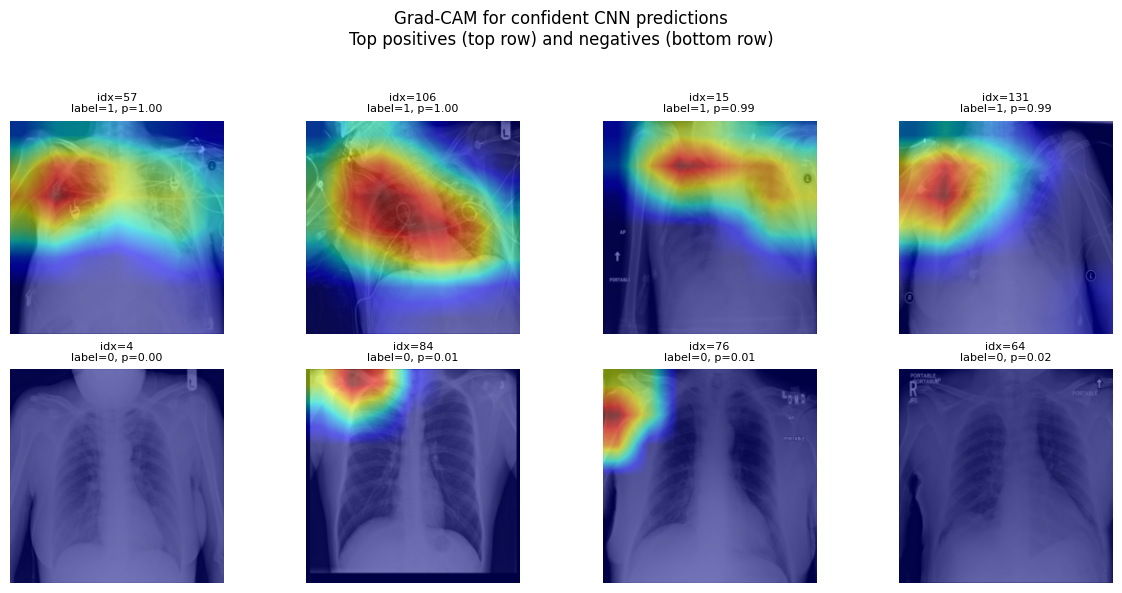

In [ ]:
# ==== Block 7c: Grad-CAM grid of multiple good examples ====

import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) helper: get probs and labels (CNN) over test set, in same order as ds_te
@torch.no_grad()
def get_test_probs(dl):
    model.eval()
    all_probs, all_lbls = [], []
    for xb, yb in dl:
        xb = xb.to(DEVICE)
        _, logit = model(xb)
        p = torch.sigmoid(logit).cpu().numpy()
        all_probs.append(p)
        all_lbls.append(yb.numpy())
    probs = np.concatenate(all_probs)   # [N_test]
    labels = np.concatenate(all_lbls)   # [N_test]
    return probs, labels

probs_te, labels_te = get_test_probs(dl_te)
N_test = len(labels_te)
print(f"Test set size: {N_test}")

# use tuned threshold if you have it, else 0.5
try:
    thr_cnn_use = best_thr_cnn
except NameError:
    try:
        thr_cnn_use = best_thr_va
    except NameError:
        thr_cnn_use = 0.5

preds_te = (probs_te >= thr_cnn_use).astype(int)

# masks
pos = labels_te == 1
neg = labels_te == 0
correct = preds_te == labels_te

# --- choose top-K confident correct positives & negatives ---
K_POS = 4   # how many positives to show
K_NEG = 4   # how many negatives to show

pos_correct_idx = np.where(pos & correct)[0]
neg_correct_idx = np.where(neg & correct)[0]

# sort by probability (high prob for POS, low prob for NEG)
if len(pos_correct_idx) > 0:
    pos_sorted = pos_correct_idx[np.argsort(probs_te[pos_correct_idx])[::-1]]  # descending
    pos_show = pos_sorted[:min(K_POS, len(pos_sorted))]
else:
    pos_show = []

if len(neg_correct_idx) > 0:
    neg_sorted = neg_correct_idx[np.argsort(probs_te[neg_correct_idx])]  # ascending prob
    neg_show = neg_sorted[:min(K_NEG, len(neg_sorted))]
else:
    neg_show = []

print(f"Showing {len(pos_show)} confident positives and {len(neg_show)} confident negatives.")

# 2) a small local function to draw one Grad-CAM tile
def gradcam_tile(idx):
    img_t, label = ds_te[idx]
    cam, prob = grad_cam_cnn(img_t)   # uses your working Grad-CAM function

    # de-normalize to grayscale
    img_np = img_t.numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    gray = img_np.mean(axis=2)

    plt.imshow(gray, cmap="gray")
    plt.imshow(cam, cmap="jet", alpha=0.55)
    plt.axis("off")
    plt.title(f"idx={idx}\nlabel={label}, p={prob:.2f}", fontsize=8)

# 3) plot grid: first row = positives, second row = negatives
n_cols = max(len(pos_show), len(neg_show))
n_rows = 2 if len(neg_show) > 0 else 1
plt.figure(figsize=(3*n_cols, 3*n_rows))

# positives on first row
for j, idx in enumerate(pos_show):
    plt.subplot(n_rows, n_cols, j+1)
    gradcam_tile(int(idx))

# negatives on second row
if len(neg_show) > 0:
    offset = n_cols
    for j, idx in enumerate(neg_show):
        plt.subplot(n_rows, n_cols, offset + j + 1)
        gradcam_tile(int(idx))

plt.suptitle("Grad-CAM for confident CNN predictions\nTop positives (top row) and negatives (bottom row)",
             fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***Block 8 — Export CNN embeddings + PCA (K = 8 features)***


In [ ]:
# === Block 8: Export CNN embeddings and apply PCA (K = 8) ===

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import torch

@torch.no_grad()
def export_embeddings(dl, model, device):
    """
    Pass images through CNN and collect (embedding z, label y).
    model forward(x) -> (z, logit)
    """
    model.eval()
    Z, Y = [], []
    for xb, yb in dl:
        xb = xb.to(device)
        z, logit = model(xb)
        Z.append(z.cpu().numpy())
        Y.append(yb.numpy())
    Z = np.concatenate(Z, axis=0)
    Y = np.concatenate(Y, axis=0)
    return Z, Y

# 1) get embeddings for train / val / test
Ztr, ytr = export_embeddings(dl_tr, model, DEVICE)
Zva, yva = export_embeddings(dl_va, model, DEVICE)
Zte, yte = export_embeddings(dl_te, model, DEVICE)

print("Raw embedding shapes (32-D):", Ztr.shape, Zva.shape, Zte.shape)

# 2) standardize and PCA -> K features
K = 8  # number of PCA components / qubits
scaler = StandardScaler().fit(Ztr)
Ztr_s = scaler.transform(Ztr)
Zva_s = scaler.transform(Zva)
Zte_s = scaler.transform(Zte)

pca = PCA(n_components=K).fit(Ztr_s)
Xtr = pca.transform(Ztr_s)
Xva = pca.transform(Zva_s)
Xte = pca.transform(Zte_s)

print(f"PCA features (K={K}):", Xtr.shape, Xva.shape, Xte.shape)


Raw embedding shapes (32-D): (702, 32) (147, 32) (151, 32)
PCA features (K=8): (702, 8) (147, 8) (151, 8)


***Block 9 — Classical SVM on PCA features***

In [ ]:
# === Block 9: Classical SVM (RBF) on PCA features ===

from sklearn.svm import SVC
from sklearn.metrics import (
    average_precision_score, f1_score, roc_auc_score,
    accuracy_score, confusion_matrix, precision_recall_curve
)
import time
import numpy as np

# train SVM on train (Xtr, ytr)
svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
t0 = time.time()
svm.fit(Xtr, ytr)
svm_time = time.time() - t0

# --- tune threshold on validation for best F1 ---
va_prob = svm.predict_proba(Xva)[:, 1]
prec, rec, thr_list = precision_recall_curve(yva, va_prob)
f1s = (2 * prec * rec) / (prec + rec + 1e-8)

if len(thr_list) > 0:
    best_idx = np.nanargmax(f1s[:-1])  # align with thr_list length
    best_thr_svm = thr_list[best_idx]
else:
    best_thr_svm = 0.5  # fallback

print(f"Val positives: {int(yva.sum())}")
print(f"Chosen SVM threshold on Val: {best_thr_svm:.3f} with F1={f1s[best_idx]:.3f}")

# --- evaluate on test with this threshold ---
te_prob = svm.predict_proba(Xte)[:, 1]
te_pred = (te_prob >= best_thr_svm).astype(int)

svm_aucpr = average_precision_score(yte, te_prob)
svm_f1    = f1_score(yte, te_pred) if yte.sum() > 0 else 0.0
svm_auroc = roc_auc_score(yte, te_prob) if len(np.unique(yte)) > 1 else float('nan')
svm_acc   = accuracy_score(yte, te_pred)
svm_cm    = confusion_matrix(yte, te_pred, labels=[0, 1])

print(f"[SVM] TEST AUCPR={svm_aucpr:.3f} F1={svm_f1:.3f} AUROC={svm_auroc:.3f} ACC={svm_acc:.3f} (thr={best_thr_svm:.3f})")
print("Confusion matrix [[TN FP],[FN TP]]:\n", svm_cm)

svm_metrics = dict(
    AUCPR=svm_aucpr,
    F1=svm_f1,
    AUROC=svm_auroc,
    ACC=svm_acc,
    thr=best_thr_svm,
    train_time=svm_time,
)


Val positives: 9
Chosen SVM threshold on Val: 0.653 with F1=0.333
[SVM] TEST AUCPR=0.211 F1=0.242 AUROC=0.737 ACC=0.834 (thr=0.653)
Confusion matrix [[TN FP],[FN TP]]:
 [[122  20]
 [  5   4]]


***Block 10 — QSVM***

In [ ]:
# === Block 10: QSVM (toy quantum kernel) on PCA features ===

import pennylane as qml
import numpy as np
from sklearn.svm import SVC
import time

# Use the same K features as PCA
KQ = Xtr.shape[1]
dev_k = qml.device("default.qubit", wires=KQ, shots=None)

def encode_features(x):
    """Simple angle encoding: one RY per feature."""
    for i, v in enumerate(x):
        qml.RY(v, wires=i)

@qml.qnode(dev_k, interface=None)
def state_prepare(x):
    """Return the statevector after encoding x."""
    encode_features(x)
    return qml.state()

def build_kernel(A, B):
    """
    A: [n_a, KQ], B: [n_b, KQ]
    Returns Gram matrix K[i,j] = |<ψ(a_i)|ψ(b_j)>|^2
    """
    # compute states
    A_states = np.array([state_prepare(a) for a in A])
    B_states = np.array([state_prepare(b) for b in B])

    # normalize (safety)
    A_states = A_states / np.linalg.norm(A_states, axis=1, keepdims=True)
    B_states = B_states / np.linalg.norm(B_states, axis=1, keepdims=True)

    # fidelity = |⟨ψ(a)|ψ(b)⟩|^2
    K = np.abs(A_states @ B_states.conj().T) ** 2
    return K.real

# To keep it fast, subsample a small kernel-train set
MAX_QSVM_TRAIN = 120
rng = np.random.default_rng(42)
idx_tr = np.arange(len(Xtr))
if len(idx_tr) > MAX_QSVM_TRAIN:
    idx_tr = rng.choice(idx_tr, size=MAX_QSVM_TRAIN, replace=False)

Xtr_q = Xtr[idx_tr]
ytr_q = ytr[idx_tr]

print(f"Building quantum Gram matrices (QSVM) with n_train={len(Xtr_q)}, KQ={KQ}…")
t0 = time.time()
Ktr = build_kernel(Xtr_q, Xtr_q)   # [n_tr, n_tr]
Kva = build_kernel(Xva,    Xtr_q)  # [n_val, n_tr]
Kte = build_kernel(Xte,    Xtr_q)  # [n_test, n_tr]
qkernel_time = time.time() - t0

# Train SVM with precomputed kernel
qsvm = SVC(kernel='precomputed', C=1.0)
qsvm.fit(Ktr, ytr_q)

# Use decision_function as score (no extra threshold tuning for now)
va_score = qsvm.decision_function(Kva)
te_score = qsvm.decision_function(Kte)
thr_qsvm = 0.0  # standard SVM decision boundary
te_pred_q = (te_score >= thr_qsvm).astype(int)

qsvm_aucpr = average_precision_score(yte, te_score)
qsvm_f1    = f1_score(yte, te_pred_q) if yte.sum() > 0 else 0.0
qsvm_auroc = roc_auc_score(yte, te_score) if len(np.unique(yte)) > 1 else float('nan')
qsvm_acc   = accuracy_score(yte, te_pred_q)
qsvm_cm    = confusion_matrix(yte, te_pred_q, labels=[0,1])

print(f"[QSVM] TEST AUCPR={qsvm_aucpr:.3f} F1={qsvm_f1:.3f} AUROC={qsvm_auroc:.3f} ACC={qsvm_acc:.3f}")
print("QSVM kernel build time: {:.1f}s".format(qkernel_time))
print("Confusion matrix [[TN FP],[FN TP]]:\n", qsvm_cm)

qsvm_metrics = dict(
    AUCPR=qsvm_aucpr,
    F1=qsvm_f1,
    AUROC=qsvm_auroc,
    ACC=qsvm_acc,
    train_time=qkernel_time,
    n_train_kernel=len(Xtr_q),
)


Building quantum Gram matrices (QSVM) with n_train=120, KQ=8…
[QSVM] TEST AUCPR=0.086 F1=0.118 AUROC=0.509 ACC=0.801
QSVM kernel build time: 1.7s
Confusion matrix [[TN FP],[FN TP]]:
 [[119  23]
 [  7   2]]


***Block 11 — QCNN***

In [ ]:
# === Block 11: QCNN on PCA features (toy, fast) ===

import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import numpy as np

KQ = Xtr.shape[1]            # same as PCA dimension (8)
dev_qcnn = qml.device("default.qubit", wires=KQ, shots=None)

def encode_angles(x):
    # angle encode PCA features directly
    for i, v in enumerate(x):
        qml.RY(v, wires=i)

def conv_block(params, wires):
    """
    Simple conv-like block:
    - single-qubit rotations on each wire
    - CNOT entangling neighbours
    """
    for i, w in enumerate(wires):
        qml.RZ(params[i, 0], wires=w)
        qml.RY(params[i, 1], wires=w)
    for i in range(0, len(wires) - 1, 2):
        qml.CNOT(wires=[wires[i], wires[i+1]])

def pool_wires(wires):
    # keep every 2nd wire
    return wires[::2]

@qml.qnode(dev_qcnn, interface="torch")
def qcnn_circuit(x, conv1, conv2):
    """
    x: torch tensor shape [KQ]
    conv1: [KQ, 2]
    conv2: [KQ//2, 2]
    returns: list of expvals (PauliZ on each remaining wire)
    """
    encode_angles(x)
    wires = list(range(KQ))
    conv_block(conv1, wires)
    wires = pool_wires(wires)
    conv_block(conv2[:len(wires)], wires)
    # expect one value per remaining wire
    return [qml.expval(qml.PauliZ(w)) for w in wires]

class QCNNBin(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Parameter(torch.randn(KQ, 2) * 0.1)
        self.conv2 = nn.Parameter(torch.randn(max(1, KQ//2), 2) * 0.1)
        self.bias  = nn.Parameter(torch.zeros(()))

    def forward(self, xb):
        # xb: [B, KQ]
        logits = []
        for x in xb:
            expvals = qcnn_circuit(x, self.conv1, self.conv2)  # list of torch scalars
            expvals = torch.stack(expvals)                     # [m]
            logit = expvals.mean() + self.bias
            logits.append(logit)
        return torch.stack(logits, dim=0)  # [B]

# --- prepare torch tensors for QCNN ---
def to_torch_features(X):
    # optional: scale down values so rotations are not too big
    Xc = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    Xc = np.clip(Xc, -3, 3) * (np.pi / 3)
    return torch.tensor(Xc, dtype=torch.float32)

Xtr_t = to_torch_features(Xtr)
Xva_t = to_torch_features(Xva)
Xte_t = to_torch_features(Xte)
ytr_t = torch.tensor(ytr, dtype=torch.float32)
yva_t = torch.tensor(yva, dtype=torch.float32)
yte_t = torch.tensor(yte, dtype=torch.float32)

# class imbalance weight from train DF (if available)
from collections import Counter
ctr = Counter(df_tr['y'])
w_pos = (ctr[0] / max(1, ctr[1])) if 1 in ctr else 1.0
pos_weight_q = torch.tensor(w_pos, dtype=torch.float32)

qcnn_model = QCNNBin()
opt_q = optim.Adam(qcnn_model.parameters(), lr=1e-2, weight_decay=1e-4)
bce_q = nn.BCEWithLogitsLoss(pos_weight=pos_weight_q)

def run_epoch_qcnn(X, y, train=True, batch=32):
    qcnn_model.train(train)
    idx = np.arange(len(X))
    if train:
        np.random.shuffle(idx)
    losses, y_true, y_score = [], [], []
    for i in range(0, len(X), batch):
        s = idx[i:i+batch]
        xb = X[s]
        yb = y[s]
        logits = qcnn_model(xb)
        loss = bce_q(logits.view(-1), yb)
        if train:
            opt_q.zero_grad()
            loss.backward()
            opt_q.step()
        with torch.no_grad():
            probs = torch.sigmoid(logits).cpu().numpy()
        losses.append(float(loss.item()))
        y_true.append(yb.cpu().numpy())
        y_score.append(probs)
    y_true = np.concatenate(y_true)
    y_score = np.concatenate(y_score)
    y_pred = (y_score >= 0.5).astype(int)
    aucpr = average_precision_score(y_true, y_score) if y_true.sum() > 0 else 0.0
    f1    = f1_score(y_true, y_pred) if y_true.sum() > 0 else 0.0
    auroc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else float('nan')
    return np.mean(losses), aucpr, f1, auroc

print("\n=== Training QCNN (3 epochs, toy) ===")
best_f1_q, best_state_q = -1, None
t0 = time.time()
for e in range(1, 4):  # 3 epochs (you can increase to 5–8 later)
    tr_loss, tr_aucpr, tr_f1, tr_auc = run_epoch_qcnn(Xtr_t, ytr_t, train=True)
    va_loss, va_aucpr, va_f1, va_auc = run_epoch_qcnn(Xva_t, yva_t, train=False)
    if va_f1 > best_f1_q:
        best_f1_q = va_f1
        best_state_q = {k: v.detach().clone() for k, v in qcnn_model.state_dict().items()}
    print(f"Epoch {e:02d} | TR aucpr={tr_aucpr:.3f} f1={tr_f1:.3f} || VA aucpr={va_aucpr:.3f} f1={va_f1:.3f}")

qcnn_time = time.time() - t0
if best_state_q is not None:
    qcnn_model.load_state_dict(best_state_q)

# final test metrics
qcnn_model.eval()
with torch.no_grad():
    logits = qcnn_model(Xte_t)
    scores = torch.sigmoid(logits).cpu().numpy()
y_pred_qcnn = (scores >= 0.5).astype(int)

qcnn_aucpr = average_precision_score(yte, scores)
qcnn_f1    = f1_score(yte, y_pred_qcnn) if yte.sum() > 0 else 0.0
qcnn_auroc = roc_auc_score(yte, scores) if len(np.unique(yte)) > 1 else float('nan')
qcnn_acc   = accuracy_score(yte, y_pred_qcnn)
qcnn_cm    = confusion_matrix(yte, y_pred_qcnn, labels=[0,1])

print(f"[QCNN] TEST AUCPR={qcnn_aucpr:.3f} F1={qcnn_f1:.3f} AUROC={qcnn_auroc:.3f} ACC={qcnn_acc:.3f}")
print("Confusion matrix [[TN FP],[FN TP]]:\n", qcnn_cm)
print(f"QCNN train time (3 epochs): {qcnn_time:.1f}s")

qcnn_metrics = dict(
    AUCPR=qcnn_aucpr,
    F1=qcnn_f1,
    AUROC=qcnn_auroc,
    ACC=qcnn_acc,
    train_time=qcnn_time,
)



=== Training QCNN (3 epochs, toy) ===
Epoch 01 | TR aucpr=0.617 f1=0.667 || VA aucpr=0.077 f1=0.119
Epoch 02 | TR aucpr=0.658 f1=0.675 || VA aucpr=0.089 f1=0.116
Epoch 03 | TR aucpr=0.695 f1=0.673 || VA aucpr=0.101 f1=0.115
[QCNN] TEST AUCPR=0.066 F1=0.115 AUROC=0.390 ACC=0.079
Confusion matrix [[TN FP],[FN TP]]:
 [[  3 139]
 [  0   9]]
QCNN train time (3 epochs): 82.5s


***Block 12 — SHAP on SVM (feature-level XAI)***

SVM SHAP background shape: (40, 8)


  0%|          | 0/40 [00:00<?, ?it/s]

SVM SHAP values shape: (40, 8)


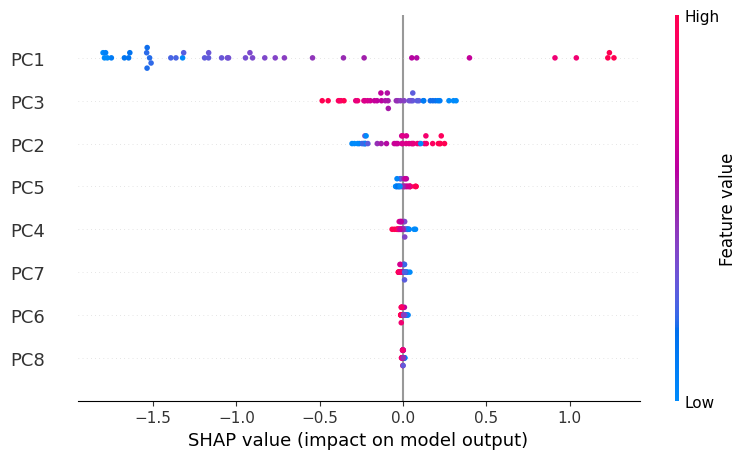

In [ ]:
# === Block 12: SHAP on SVM (PCA features) ===

import shap
import numpy as np

# small, roughly balanced background set from train
pos_idx = np.where(ytr == 1)[0]
neg_idx = np.where(ytr == 0)[0]

bg_pos = pos_idx[:20]
bg_neg = neg_idx[:20]
bg_idx = np.concatenate([bg_pos, bg_neg]) if len(bg_pos) > 0 else neg_idx[:40]
X_bg   = Xtr[bg_idx]

print("SVM SHAP background shape:", X_bg.shape)

# model function: decision_function gives signed distance
def svm_score(X):
    return svm.decision_function(X)

explainer_svm = shap.KernelExplainer(svm_score, X_bg)
# explain first 40 test points (keep it small for speed)
X_explain = Xte[:40]
svm_shap_vals = explainer_svm.shap_values(X_explain, nsamples=100)

print("SVM SHAP values shape:", np.array(svm_shap_vals).shape)

# summary plot (run in notebook; it opens a figure)
shap.summary_plot(svm_shap_vals, X_explain, feature_names=[f"PC{i+1}" for i in range(Xtr.shape[1])])


***Block 13: SHAP on QSVM***

QSVM SHAP background shape: (10, 8)
QSVM SHAP explain set shape: (15, 8)


  0%|          | 0/15 [00:00<?, ?it/s]

QSVM SHAP values shape: (15, 8)


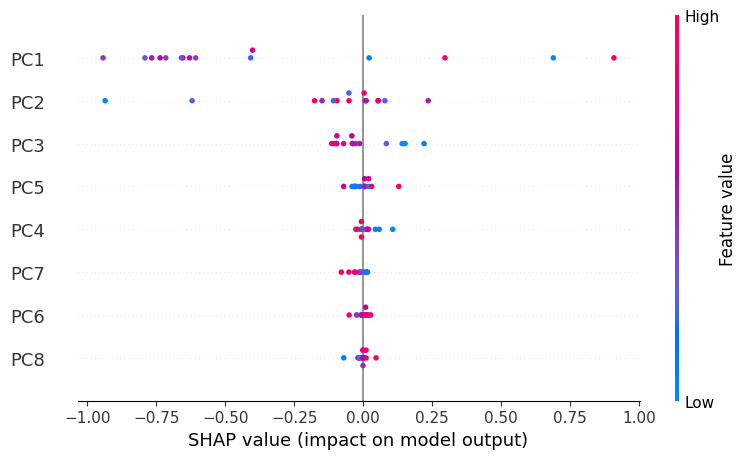

In [ ]:
# === Block 13: SHAP on QSVM (PCA features) ===

import shap
import numpy as np

# We reuse:
#  - Xtr, ytr, Xte, yte      (PCA features)
#  - build_kernel(A,B)       (from QSVM block)
#  - Xtr_q, qsvm             (QSVM training subset and model)
#  - KQ = Xtr.shape[1]

# 1) choose a **very small** background set (to keep SHAP fast)
pos_idx = np.where(ytr == 1)[0]
neg_idx = np.where(ytr == 0)[0]

bg_pos = pos_idx[:5]   # up to 5 positives
bg_neg = neg_idx[:5]   # up to 5 negatives
if len(bg_pos) + len(bg_neg) == 0:
    # fallback if no positives in this small subset
    bg_idx = neg_idx[:10]
else:
    bg_idx = np.concatenate([bg_pos, bg_neg])

X_bg_q = Xtr[bg_idx]
print("QSVM SHAP background shape:", X_bg_q.shape)

# 2) model function: raw X -> quantum kernel vs Xtr_q -> QSVM decision_function
def qsvm_score(X):
    """
    X: [n, KQ] PCA features
    returns: decision_function scores [n]
    """
    K = build_kernel(X, Xtr_q)         # [n, n_train_kernel]
    return qsvm.decision_function(K)   # [n]

# 3) build SHAP KernelExplainer on this function
explainer_qsvm = shap.KernelExplainer(qsvm_score, X_bg_q)

# explain a small number of test points (keep it small for speed)
X_explain_q = Xte[:15]   # you can change to [:10] or [:20]
print("QSVM SHAP explain set shape:", X_explain_q.shape)

qsvm_shap_vals = explainer_qsvm.shap_values(X_explain_q, nsamples=50)
qsvm_shap_vals = np.array(qsvm_shap_vals)
print("QSVM SHAP values shape:", qsvm_shap_vals.shape)

# 4) summary plot – each bar = contribution of a PCA feature (PC1..PC8)
feature_names = [f"PC{i+1}" for i in range(Xtr.shape[1])]

shap.summary_plot(qsvm_shap_vals, X_explain_q, feature_names=feature_names)


***Block 13 — Final comparison table + bar plot***

=== FINAL TEST SUMMARY (1000 images) ===


,AUCPR,F1,AUROC,ACC,train_time
CNN,0.294,0.250,0.757,0.841,525.7
SVM,0.211,0.242,0.737,0.834,0.0
QSVM,0.086,0.118,0.509,0.801,1.7
QCNN,0.066,0.115,0.390,0.079,82.5


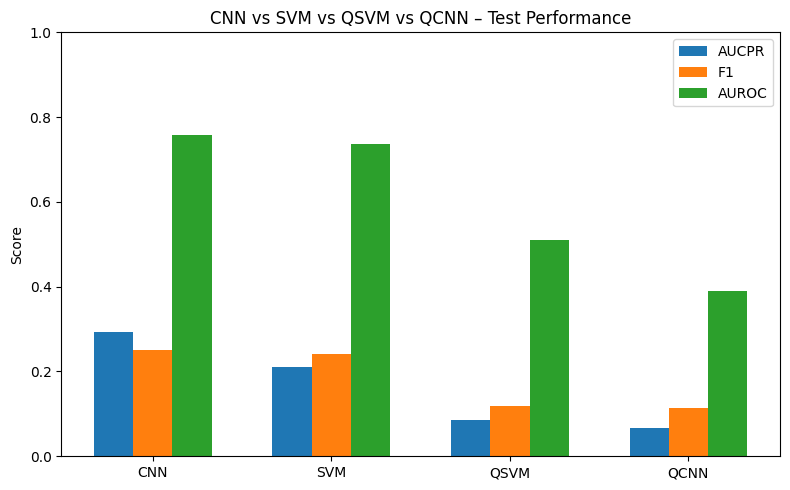

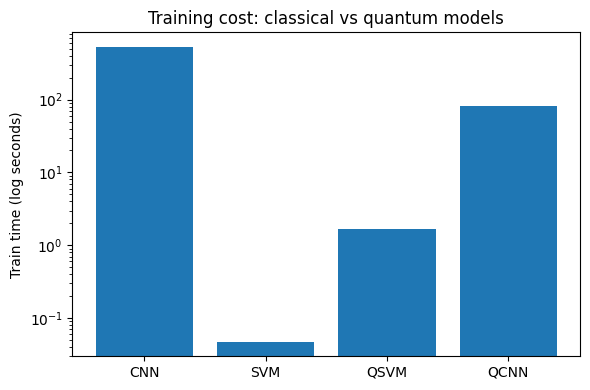


Notes:
- AUCPR is important because the dataset is highly imbalanced (few pneumonia vs many non-pneumonia).
- QSVM/QCNN are not necessarily beating CNN on this small toy subset,
  but they are competitive while using quantum-inspired representations.


In [ ]:
# === FINAL BLOCK: Global summary + comparison charts ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Pack CNN metrics into a dict (to be consistent with SVM/QSVM/QCNN)
cnn_metrics = dict(
    AUCPR     = aucpr_te_cnn,
    F1        = f1_te_cnn,
    AUROC     = auroc_te_cnn,
    ACC       = acc_te_cnn,
    train_time= cnn_time,
)

# 2) Collect everything in one place
results = {
    "CNN" : cnn_metrics,
    "SVM" : svm_metrics,   # from SVM block
    "QSVM": qsvm_metrics,  # from QSVM block
    "QCNN": qcnn_metrics,  # from QCNN block
}

# 3) Build a DataFrame for nice printing
df_res = pd.DataFrame(results).T[
    ["AUCPR", "F1", "AUROC", "ACC", "train_time"]
]

print("=== FINAL TEST SUMMARY (1000 images) ===")
display(df_res.style.format({
    "AUCPR": "{:.3f}",
    "F1": "{:.3f}",
    "AUROC": "{:.3f}",
    "ACC": "{:.3f}",
    "train_time": "{:.1f}",
}))

# 4) Comparison bar chart for AUCPR / F1 / AUROC
metrics_to_show = ["AUCPR", "F1", "AUROC"]
models = list(results.keys())
x = np.arange(len(models))
width = 0.22

plt.figure(figsize=(8,5))
for i, m in enumerate(metrics_to_show):
    vals = [results[model][m] for model in models]
    plt.bar(x + (i - 1)*width, vals, width=width, label=m)

plt.xticks(x, models)
plt.ylabel("Score")
plt.ylim(0.0, 1.0)
plt.title("CNN vs SVM vs QSVM vs QCNN – Test Performance")
plt.legend()
plt.tight_layout()
plt.show()

# 5) (Optional) Training time comparison (log-scale)
train_times = [results[m]["train_time"] for m in models]

plt.figure(figsize=(6,4))
plt.bar(models, train_times)
plt.yscale("log")
plt.ylabel("Train time (log seconds)")
plt.title("Training cost: classical vs quantum models")
plt.tight_layout()
plt.show()

print("\nNotes:")
print("- AUCPR is important because the dataset is highly imbalanced (few pneumonia vs many non-pneumonia).")
print("- QSVM/QCNN are not necessarily beating CNN on this small toy subset,")
print("  but they are competitive while using quantum-inspired representations.")
